In [104]:
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
%matplotlib inline

def plot_gradient(samples, md, ax):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    cmap = sns.cubehelix_palette(as_cmap=True)
    ax.scatter(samples.loc[:, 'PC1'], samples.loc[:, 'PC2']
               ,c=md['Gradient'], s=10, cmap=cmap)   
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2', fontsize=14)    
    ax.set_xlabel('PC1', fontsize=14)
    return ax
def plot_clusters(samples, md, ax):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    idx = md['Cluster'] == 'Cluster 1'
    ax.scatter(samples.loc[idx, 'PC1'], samples.loc[idx, 'PC2'], label='Cluster 1')   
    ax.scatter(samples.loc[~idx, 'PC1'], samples.loc[~idx, 'PC2'], label='Cluster 2')    
    
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2', fontsize=14)    
    ax.set_xlabel('PC1', fontsize=14)
    return ax

plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.style.use('ggplot')
sns.set_style('whitegrid')

In [109]:
#import a few ordinations to plot
clust=['2_20_1000_PCA','2_20_1000_RPCA',
     '2_20_10000_PCA','2_20_10000_RPCA']
clustord=pd.concat({tuple(x.split('_')):pd.read_csv('cluster_models/ordination/'+x+'.csv',
                                                   index_col=0) for x in clust},axis=0)[['PC1','PC2']]

grad=['1.0_1000.0_PCA','1.0_1000.0_RPCA',
     '1.0_2000.0_PCA','1.0_2000.0_RPCA']
gradord=pd.concat({tuple(x.split('_')):pd.read_csv('gradient_models/ordination/'+x+'.csv',
                                                  index_col=0) for x in grad},axis=0)[['PC1','PC2']]


#import and view results from simuilation
cluster_results=pd.read_csv('cluster_models/results.csv')
gradient_results=pd.read_csv('gradient_models/results.csv')
display_side_by_side(cluster_results.head(10),gradient_results.head(10))


,Rank,Overlap,Sequence_Depth,Method,Metric,value
0,2,0,100,IterativeSVD,KL-Div,34.249382
1,2,0,100,KNN,KL-Div,34.072478
2,2,0,100,OptSpace,KL-Div,31.369337
3,2,0,100,SoftImpute,KL-Div,32.568129
4,2,0,100,rclr-IterativeSVD,KL-Div,0.002227
5,2,0,100,rclr-KNN,KL-Div,0.002259
6,2,0,100,rclr-OptSpace,KL-Div,0.002246
7,2,0,100,rclr-SoftImpute,KL-Div,0.002212
8,2,0,1000,IterativeSVD,KL-Div,52.034154
9,2,0,1000,KNN,KL-Div,53.379476


In [110]:
processing={2:'Preprocessed',1:'No-Preprocessing'}
cluster_results['Proc']=[processing[len(x.split('rclr'))] for x in cluster_results.Method]
gradient_results['Proc']=[processing[len(x.split('rclr'))] for x in gradient_results.Method]



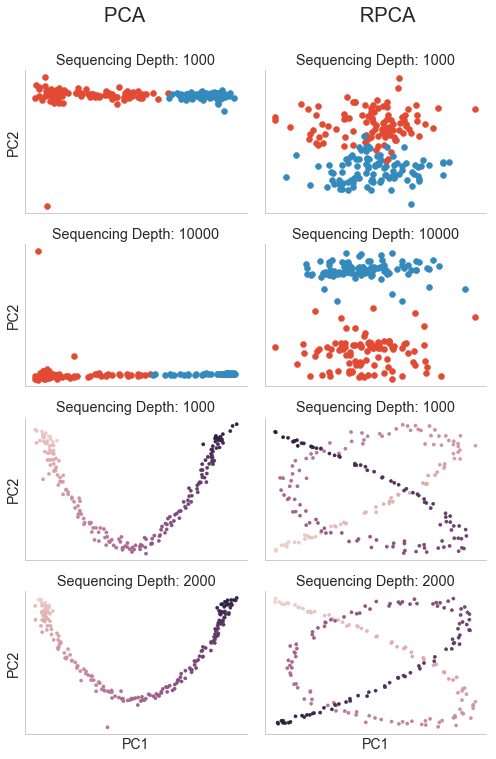

In [111]:
rank_=clustord.index.get_level_values(0).unique()[0]
overlap_=clustord.index.get_level_values(1).unique()[0]
depths_=list(clustord.index.get_level_values(2).unique()) #seq depth
method_=list(clustord.index.get_level_values(3).unique())*len(depths_)
depths_=list(np.sort(depths_*2))

sigma_=gradord.index.get_level_values(0).unique()[0]
depths_sigma=list(gradord.index.get_level_values(1).unique()) #seq depth
method_sigma=list(gradord.index.get_level_values(2).unique())*len(depths_sigma)
depths_sigma=list(np.sort(depths_sigma*2))


fig,axn = plt.subplots(4,2,figsize=(7,10))
flatax_=axn.flat

for (count_,ax_),seq_,mthd_ in zip(enumerate(flatax_)
                                   ,depths_+depths_sigma,method_+method_sigma):
    
    if count_<4:
        clustmp=clustord.loc[(rank_,overlap_,seq_,mthd_,),:]    
        if count_==0:
            clustmap={**{'sample_'+str(x):['Cluster 1'] for x in range(int(clustmp.shape[0]/int(rank_)))},
                    **{'sample_'+str(x):['Cluster 2'] for x in range(int(clustmp.shape[0]/int(rank_))
                                                                  ,int(clustmp.shape[0]))}}
            clustmap=pd.DataFrame(clustmap,index=['Cluster']).T

        plot_clusters(clustmp,clustmap,ax_)
        ax_.set_title('Sequencing Depth: '+seq_)
        if count_%2==1:
            ax_.set_ylabel('')
        if count_ not in [6,7]:
            ax_.set_xlabel('')
    else:
        gradmp=gradord.loc[(sigma_,seq_,mthd_,),:]    
        gradmap=pd.DataFrame(list(range(gradmp.shape[0])),
                             index=gradmp.index,columns=['Gradient'])

        plot_gradient(gradmp,gradmap,ax_)
        ax_.set_title('Sequencing Depth: '+seq_.split('.')[0])
        if count_%2==1:
            ax_.set_ylabel('')
        if count_ not in [6,7]:
            ax_.set_xlabel('')       
            
                
plt.suptitle('    PCA                                       RPCA',fontsize=20,y=1.05,x=.50)
plt.tight_layout()
fig.savefig('figures/figure3a.png')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


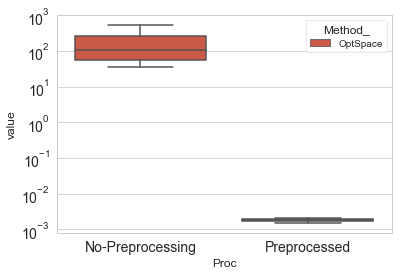

In [103]:
cluster_results['Method_']=[x.replace('rclr-','') for x in cluster_results.Method]
cluster_results_plot=cluster_results[cluster_results.Overlap.isin([20])][cluster_results.Method_.isin(['OptSpace'])]

sns.boxplot(x='Proc',y='value',hue='Method_',data=cluster_results_plot)
plt.yscale('log')
plt.show()


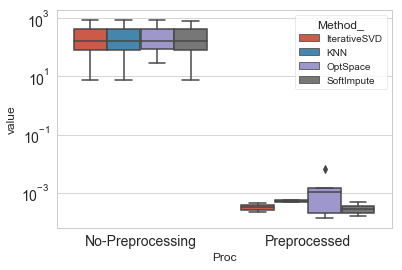

In [77]:
gradient_results['Method_']=[x.replace('rclr-','') for x in gradient_results.Method]
gradient_results_plot=gradient_results[gradient_results.Band_Width.isin([1.7])]

sns.boxplot(x='Proc',y='value',hue='Method_',data=gradient_results_plot)
plt.yscale('log')
plt.show()


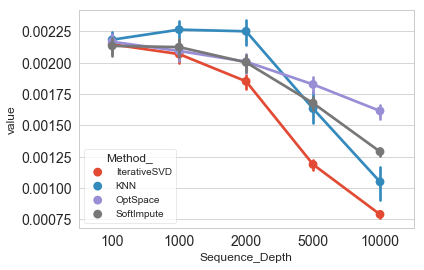

In [73]:
cluster_results_plot=cluster_results[cluster_results.Proc.isin(['Preprocessed'])]

sns.pointplot(x='Sequence_Depth',y='value',hue='Method_',data=cluster_results_plot)
plt.show()


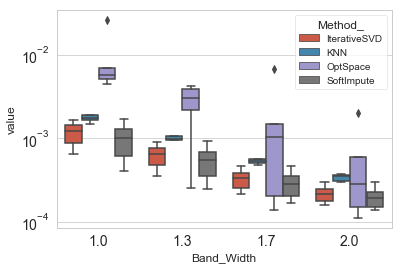

In [81]:
gradient_results_plot=gradient_results[gradient_results.Proc.isin(['Preprocessed'])]

sns.boxplot(x='Band_Width',y='value',hue='Method_',data=gradient_results_plot)
plt.yscale('log')
plt.show()

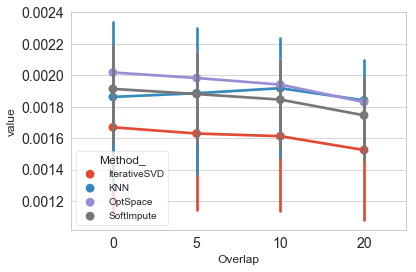

In [74]:
cluster_results_plot=cluster_results[cluster_results.Proc.isin(['Preprocessed'])]

sns.pointplot(x='Overlap',y='value',hue='Method_',data=cluster_results_plot)
plt.show()


In [75]:
cluster_results.columns

Index(['Rank', 'Overlap', 'Sequence_Depth', 'Method', 'Metric', 'value',
       'Proc', 'Method_'],
      dtype='object')

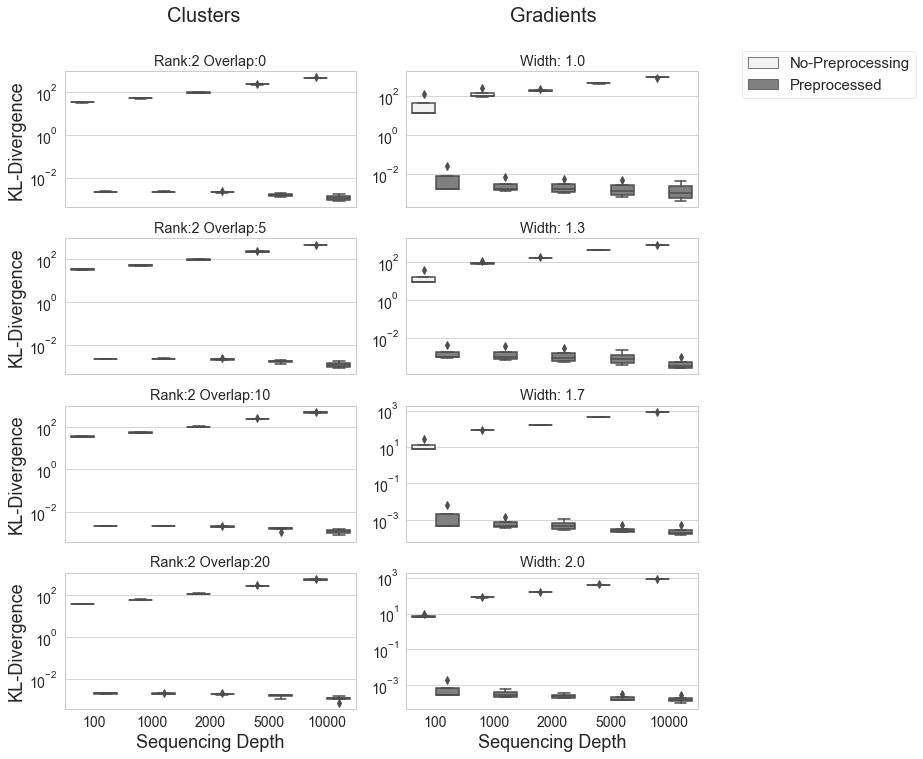

In [57]:
palette_map={'KNN': '#CB77FF',
             'rclr-KNN': '#cab2d6',
             'SoftImpute': '#FF7777',
             'rclr-SoftImpute': '#fb9a99',
             'OptSpace': '#6ECF7A',
             'rclr-OptSpace': '#b2df8a',
                'IterativeSVD': '#1f78b4',
            'rclr-IterativeSVD':'#a6cee3'}

clusters={key_:df_ for key_,df_ in cluster_results.groupby(['Rank','Overlap'])}
gradients={key_:df_ for key_,df_ in gradient_results.groupby(['Band_Width'])}
all_clgr={**clusters,**gradients}

fig,axn = plt.subplots(4,2,figsize=(13,10),sharex=True,sharey=False)

flatax_=axn.flat
for (key_,df_),(use_) in zip(all_clgr.items(),[0,2,4,6,1,3,5,7]):
    
    ax_=flatax_[use_]
    if type(key_)==tuple:
        key_='Rank:'+' Overlap:'.join([str(x) for x in list(key_)])
    else:
        key_='Width: '+str(key_)
    df_['Sequence_Depth']=df_['Sequence_Depth'].astype(int)
    sns.boxplot(x='Sequence_Depth',y='value',hue='Proc',data=df_,ax=ax_,color='gray')
    #sns.swarmplot(x='Sequence_Depth',y='value',hue='Method',data=df_,ax=ax_,palette=palette_map)
    if use_ not in [7,6]:
        ax_.set_xlabel('')
    else:
        ax_.set_xlabel('Sequencing Depth',fontsize=18)
    if use_%2!=0:
        ax_.set_ylabel('')
    else:
        ax_.set_ylabel('KL-Divergence',fontsize=18)
    ax_.set_yscale('log')
    if use_==1:
        ax_.legend(bbox_to_anchor=(1.15, 1.15), loc=2, borderaxespad=0.,prop={'size':15})
    else:
        ax_.legend_.remove()
    ax_.set_title(key_)
    
plt.suptitle('    Clusters                                                 Gradients',fontsize=20,y=1.05,x=.40)
plt.tight_layout()   
fig.savefig('figures/figure3b.png')
plt.show()
